# **Forecasting Solar Radiation**

Solar radiation is essential for calculating two key metrics in sustainable land management, which help farmers evaluate the level of photosynthesis occurring:

   -  Evapotranspiration
   -  Daily Light Integral (DLI)

These metrics enable farmers to optimize irrigation and fertilizer use for more precise and effective crop management.

Problem :
- Solar Radiation data are often either : expensive (for individuals)  
- Nasa's Solar Radiation Data are free, but there are 5 days buffer from measure to display

Goal :
- Forecasting next days (at least 5 to cover the buffer) Solar radiation value from past days values

## **Model 1 : Seasonal and/or AutoRegressive and/or Moving Average**
*Motivations :*
1. Sarimax performs often performs well with Seasonality: as Solar Radiation shouls be impacted by seasons and earth inclination,

2. Trend: There might be a trend as Solar Radiation may be quite similar from one season to another (increasing from Winter to Summer, Decreasing from Summer to winter)

3. Autocorrelation: The data shows autocorrelation, meaning past values have a statistical relationship with future values. SARIMAX accounts for autoregressive (AR) and moving average (MA) components.

***Results :***
Bad : 55.58% (MAPE) --> probably because of cloud measure interference


### Required libraries

In [ ]:
!pip install scalecast

In [ ]:
import json
import requests
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scalecast.Forecaster import Forecaster

### Request Data from Nasa
https://power.larc.nasa.gov/


In [ ]:
'''
entries : start_data and end_date are in format YYYYMMDD
return ; a dictionnary/json  with keys = date & values = solar radiation
'''
def get_solar_radiation_data(start_date, end_date):
    url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=ALLSKY_SFC_SW_DWN&community=RE&longitude=2.3522&latitude=48.8566&start={start_date}&end={end_date}&format=JSON"
    response = requests.get(url)
    data = json.loads(response.text)
    return data['properties']['parameter']['ALLSKY_SFC_SW_DWN']

### Data preprocessing

In [ ]:
# Call function from 2 years ago to now
end_date = datetime.now()
start_date = (datetime.now() - timedelta(days=730)).strftime("%Y%m%d")
data = get_solar_radiation_data(start_date, (end_date- timedelta(days=5)).strftime("%Y%m%d"))

# Convert received json into a pandas dataframe
df = pd.DataFrame(list(data.items()), columns=['Date', 'Radiation'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

### Training

In [ ]:
# Train/Test Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
f = Forecaster(y=df['Radiation'],
current_dates=df.index
)

### Plot Part Autocorrelation and Autocorrelation

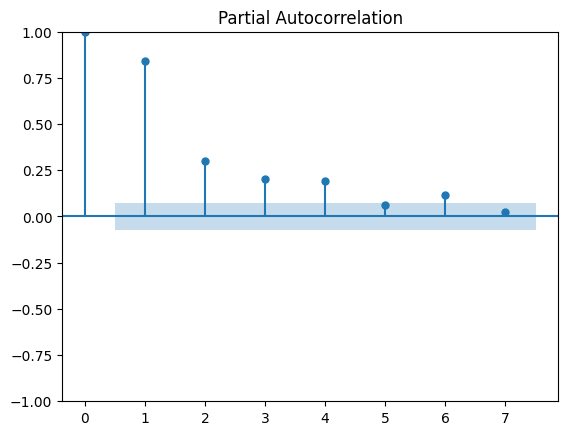

In [ ]:
f.plot_pacf(lags=7)
plt.show()

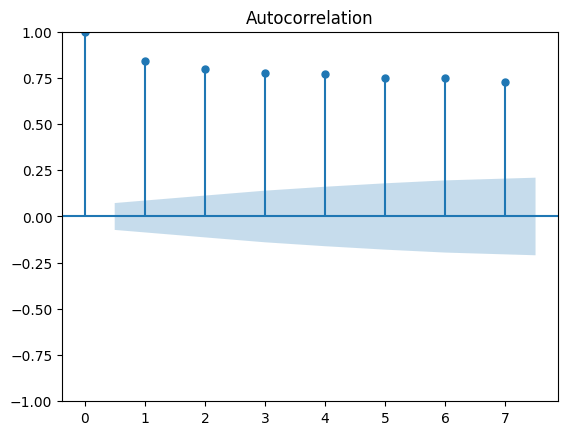

In [ ]:
f.plot_acf(lags=7)
plt.show()

### Plot Seasonality

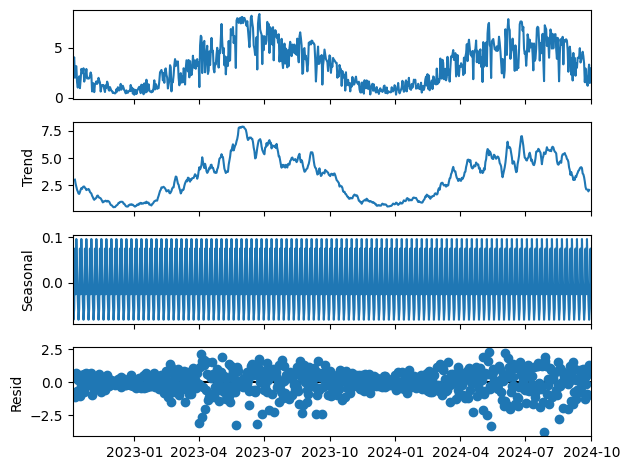

In [ ]:
f.seasonal_decompose().plot()
plt.show()

### Statistical Test for model relevancy validation

In [ ]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
stat

-1.612648530428011

In [ ]:
pval

0.4765854337319262

### Grid search to get best results

In [ ]:
models = [
    (1,0,1),
    (1,1,1),
    (2,0,1),
    (2,1,1)
]

# Fonction pour évaluer un modèle ARIMA
def evaluate_arima_model(order):
    model = SARIMAX(series, order=order)
    results = model.fit(disp=False)
    return results.aic, results

# Évaluer tous les modèles
best_aic = float("inf")
best_model = None
best_order = None

for order in models:
    try:
        aic, model = evaluate_arima_model(order)
        if aic < best_aic:
            best_aic = aic
            best_model = model
            best_order = order
        print(f'ARIMA{order} AIC: {aic}')
    except:
        continue

print(f'\nMeilleur modèle : ARIMA{best_order} avec AIC: {best_aic}')

# Utiliser le meilleur modèle pour les prévisions
n_test = 10
train = series[:-n_test]

ARIMA(1, 0, 1) AIC: 7366.649119058145
ARIMA(1, 1, 1) AIC: 7353.605529532531
ARIMA(2, 0, 1) AIC: 7367.375318681929
ARIMA(2, 1, 1) AIC: 7355.605317643489

Meilleur modèle : ARIMA(1, 1, 1) avec AIC: 7353.605529532531


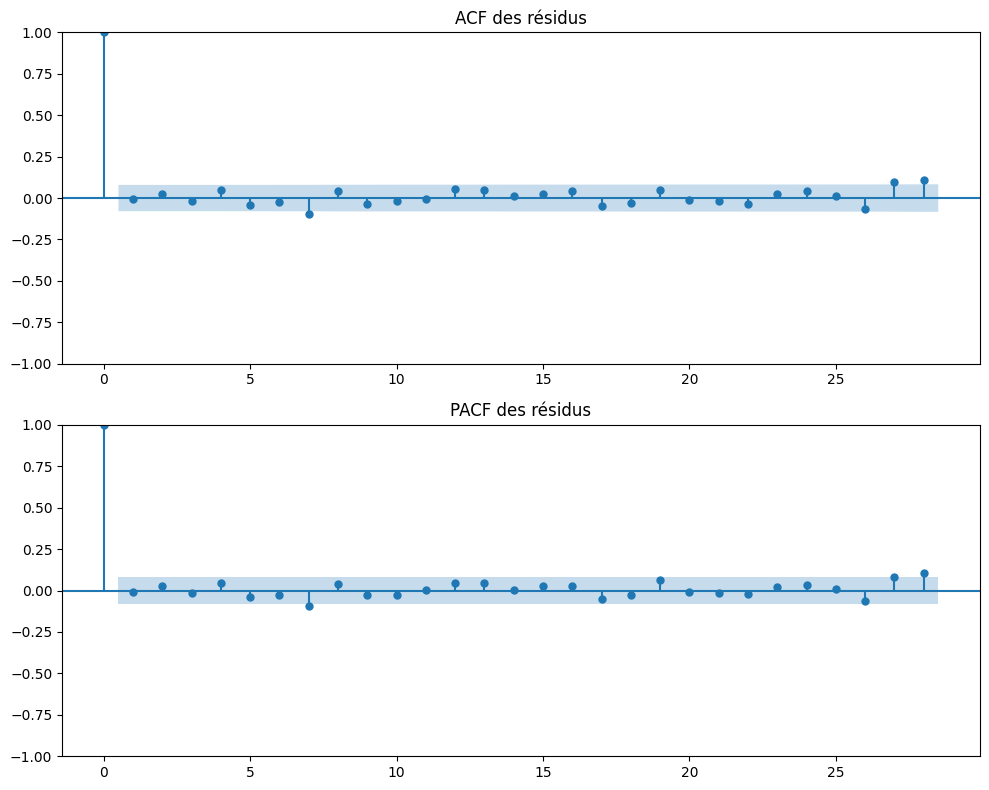

Test de normalité des résidus : p-value = 1.4317039777538234e-06

RMSE sur les 10 dernières valeurs: 205.09096266350758


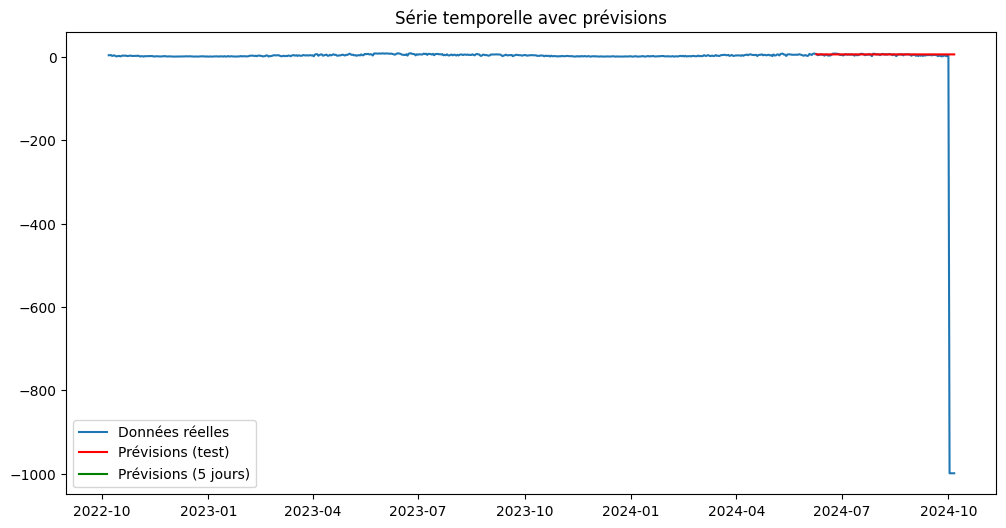

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Supposons que 'series' est votre série temporelle

# Paramètres du meilleur modèle
best_order = (1, 1, 1)

# Séparation des données d'entraînement et de test
n_test = 120
train = series[:-n_test]
test = series[-n_test:]

# Ajustement du modèle
model = SARIMAX(train, order=best_order)
results = model.fit(disp=False)

# Vérification des résidus
residuals = results.resid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, ax=ax1, title='ACF des résidus')
plot_pacf(residuals, ax=ax2, title='PACF des résidus')
plt.tight_layout()
plt.show()

# Test de normalité des résidus
from scipy import stats
_, p_value = stats.normaltest(residuals)
print(f"Test de normalité des résidus : p-value = {p_value}")

# Prévisions sur l'ensemble de test
forecast = results.forecast(steps=n_test)
rmse = sqrt(mean_squared_error(test, forecast))
print(f'\nRMSE sur les 10 dernières valeurs: {rmse}')



# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label='Données réelles')
plt.plot(forecast.index, forecast, color='red', label='Prévisions (test)')
plt.plot(forecast_final.index[n_test:], forecast_final[n_test:], color='green', label='Prévisions (5 jours)')
plt.legend()
plt.title('Série temporelle avec prévisions')
plt.show()


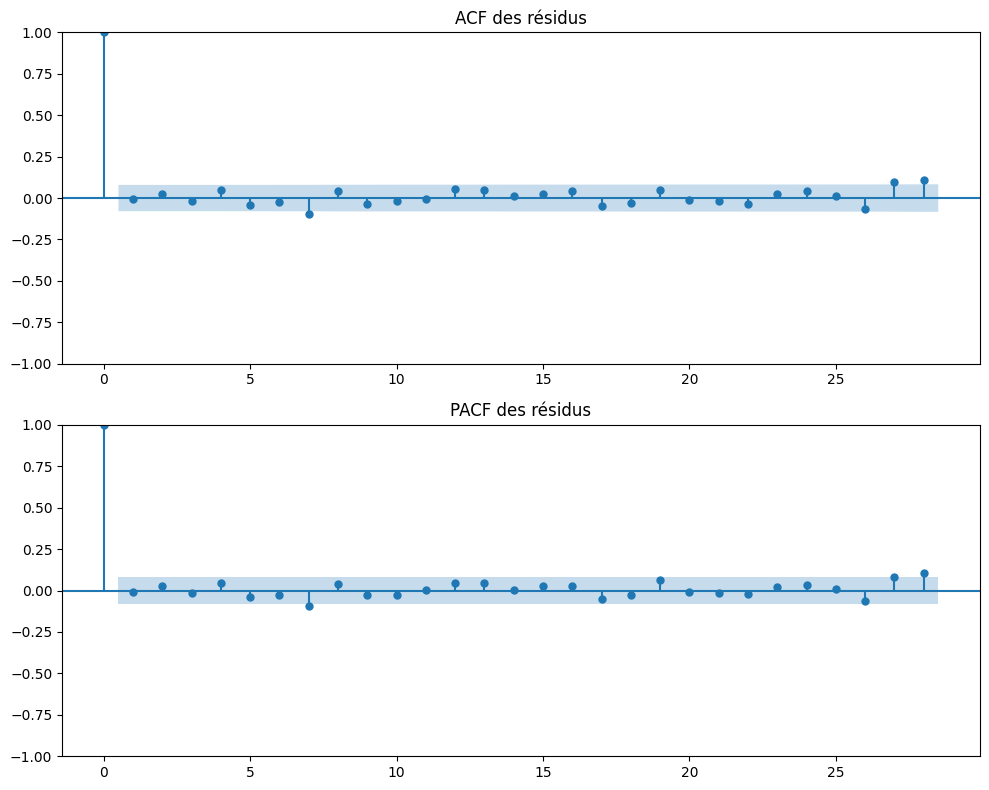

Test de normalité des résidus : p-value = 1.4317039777538234e-06

RMSE sans les 5 derniers jours: 1.901778342328761

MAPE sans les 5 derniers jours: 52.38%


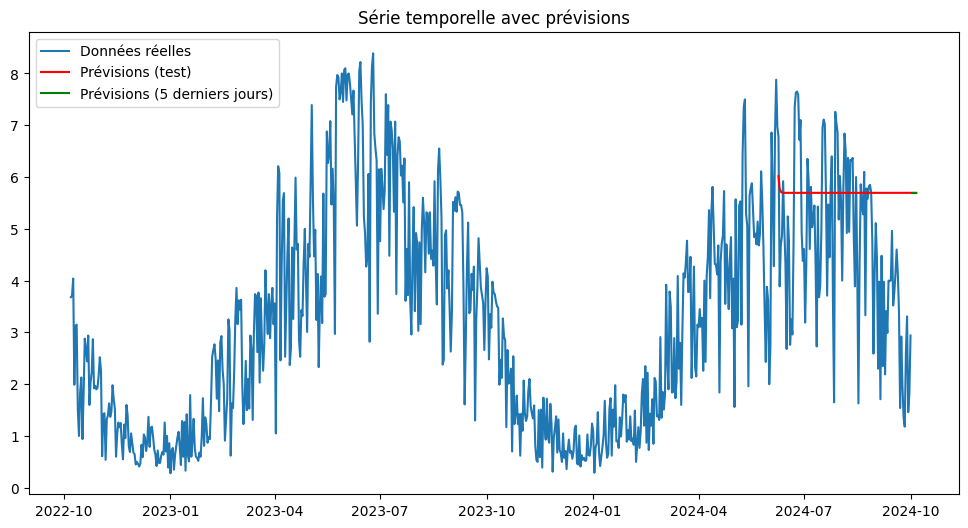

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Paramètres du meilleur modèle
best_order = (1, 1, 1)

# Remplacer les -999 par NaN dans la série pour les derniers 5 jours
series = series.replace(-999, np.nan)

# Séparation des données d'entraînement et de test
n_test = 120
train = series[:-n_test]
test = series[-n_test:]

# Ajustement du modèle
model = SARIMAX(train, order=best_order)
results = model.fit(disp=False)

# Vérification des résidus
residuals = results.resid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, ax=ax1, title='ACF des résidus')
plot_pacf(residuals, ax=ax2, title='PACF des résidus')
plt.tight_layout()
plt.show()

# Test de normalité des résidus
from scipy import stats
_, p_value = stats.normaltest(residuals)
print(f"Test de normalité des résidus : p-value = {p_value}")

# Prévisions sur l'ensemble de test
forecast = results.forecast(steps=n_test)

# Supprimer les 5 derniers jours du test et de la prévision pour éviter l'impact des -999
test_valid = test[:-5]
forecast_valid = forecast[:-5]

# Calcul du RMSE en excluant les 5 derniers jours
rmse = sqrt(mean_squared_error(test_valid, forecast_valid))
print(f'\nRMSE sans les 5 derniers jours: {rmse}')

# Fonction pour calculer le MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calcul du MAPE en excluant les 5 derniers jours
mape = mean_absolute_percentage_error(test_valid, forecast_valid)
print(f'\nMAPE sans les 5 derniers jours: {mape:.2f}%')

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label='Données réelles')
plt.plot(forecast.index, forecast, color='red', label='Prévisions (test)')
plt.plot(forecast.index[-5:], forecast[-5:], color='green', label='Prévisions (5 derniers jours)')
plt.legend()
plt.title('Série temporelle avec prévisions')
plt.show()


## **Model 2 : Pseudo Markovian/Seasoned Model**
As the Sarimax model performed very bad (55.58% (MAPE)):
It is likely coming from the interference caused by clouds and other weather phenomena between soil sensors and the Sun.

- Consequently, a model taking into account clouds opacity should be relevant to train. However we didn't have that time during the challenge.

- That's why we made following assumptions :  
    - not relevant to take into account in the formula too many former days, as cloud movement is likely to change, but not so much from one day to the day after --> take only the former day
    - However, still need historical data to cover the obvious seasonality --> the day exactly one year before

Résultats du test sur 20% des données:
Erreur absolue moyenne (MAE): 1.30
Racine de l'erreur quadratique moyenne (RMSE): 1.55
Erreur pourcentage moyenne (MPE): -8.57%

Prédictions pour les 5 derniers jours après la dernière date valide:
20241002: Prédit = 2.21
20241003: Prédit = 2.62
20241004: Prédit = 2.46
20241005: Prédit = 2.88
20241006: Prédit = 2.75


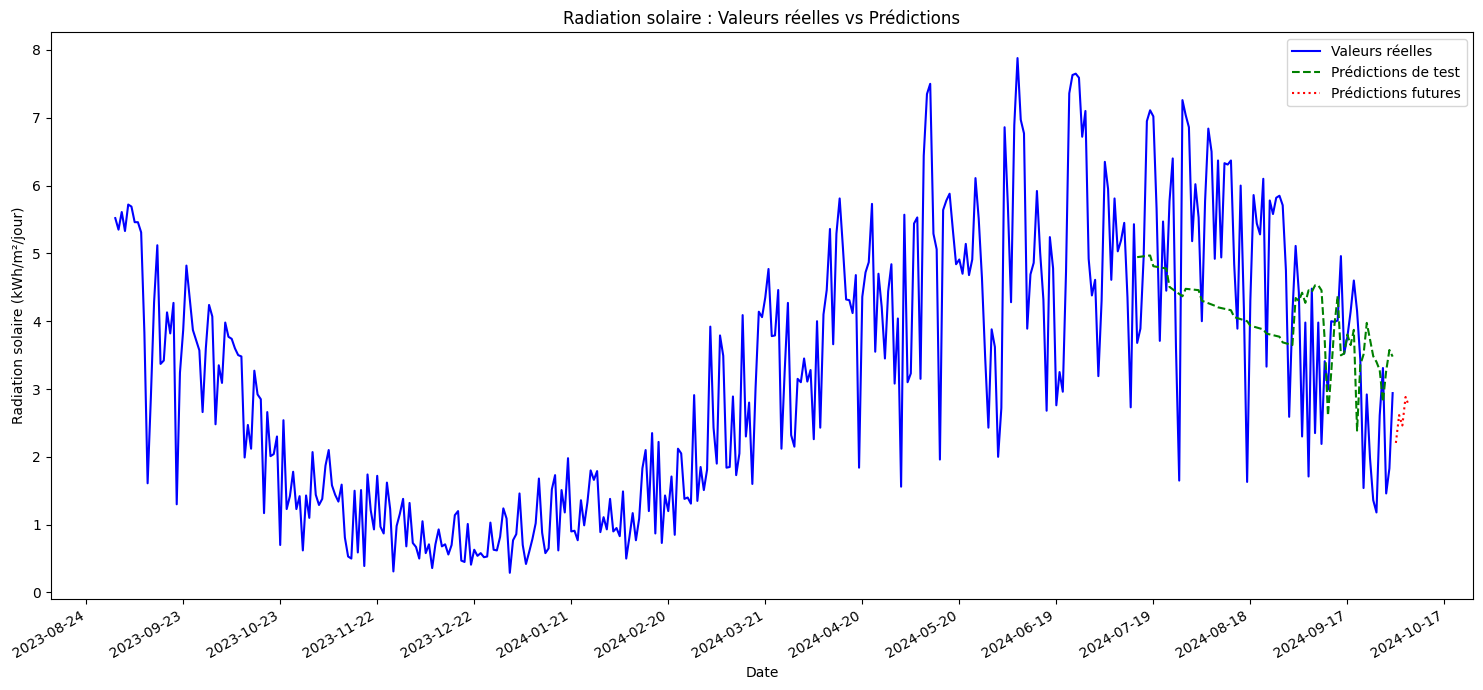

In [ ]:
import requests
import json
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as pltpower.larc.nasa
import matplotlib.dates as mdates

def get_solar_radiation_data(start_date, end_date):
    url = f"https://.gov/api/temporal/daily/point?parameters=ALLSKY_SFC_SW_DWN&community=RE&longitude=2.3522&latitude=48.8566&start={start_date}&end={end_date}&format=JSON"
    response = requests.get(url)
    data = json.loads(response.text)
    return data['properties']['parameter']['ALLSKY_SFC_SW_DWN']

def predict_missing_data(data, days_to_predict=5):
    valid_data = {k: v for k, v in data.items() if v != -999}
    values = np.array(list(valid_data.values()))

    last_date = datetime.strptime(list(valid_data.keys())[-1], "%Y%m%d")
    previous_year_data = []
    for i in range(days_to_predict):
        date = last_date + timedelta(days=i+1)
        previous_year_date = (date - timedelta(days=365)).strftime("%Y%m%d")
        if previous_year_date in valid_data:
            previous_year_data.append(valid_data[previous_year_date])
        else:
            previous_year_data.append(np.mean(values[-30:]))

    X = np.arange(30).reshape(-1, 1)
    y = values[-30:]
    model = LinearRegression().fit(X, y)

    X_pred = np.arange(30, 30 + days_to_predict).reshape(-1, 1)
    linear_predictions = model.predict(X_pred)

    final_predictions = 0.5 * np.array(previous_year_data) + 0.5 * linear_predictions

    new_data = {}
    for i in range(days_to_predict):
        date = (last_date + timedelta(days=i+1)).strftime("%Y%m%d")
        new_data[date] = final_predictions[i] - 0.22 # Applique le décalage de -0.75

    return new_data

def mean_percentage_error(y_true, y_pred):
    return np.mean((y_true - y_pred) / y_true) * 100

def test_model(data):
    valid_data = {k: v for k, v in data.items() if v != -999}
    total_size = len(valid_data)
    train_size = int(total_size * 0.8)
    test_size = total_size - train_size

    train_data = dict(list(valid_data.items())[:train_size])
    test_data = dict(list(valid_data.items())[train_size:])

    predictions = {}
    for i in range(0, test_size, 5):
        temp_train = dict(list(train_data.items()) + list(predictions.items()))
        temp_pred = predict_missing_data(temp_train, days_to_predict=5)
        predictions.update(temp_pred)

    actual = list(test_data.values())
    predicted = [predictions[date] for date in test_data.keys()]

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mpe = mean_percentage_error(np.array(actual), np.array(predicted))

    return mae, rmse, mpe, predictions, test_data

def plot_results(data, test_predictions, future_predictions):
    valid_data = {k: v for k, v in data.items() if v != -999}
    dates = [datetime.strptime(d, "%Y%m%d") for d in valid_data.keys()]
    values = list(valid_data.values())

    test_dates = [datetime.strptime(d, "%Y%m%d") for d in test_predictions.keys()]
    test_values = list(test_predictions.values())

    future_dates = [datetime.strptime(d, "%Y%m%d") for d in future_predictions.keys()]
    future_values = list(future_predictions.values())

    plt.figure(figsize=(15, 7))
    plt.plot(dates, values, label='Valeurs réelles', color='blue')
    plt.plot(test_dates, test_values, label='Prédictions de test', color='green', linestyle='--')
    plt.plot(future_dates, future_values, label='Prédictions futures', color='red', linestyle=':')

    plt.title('Radiation solaire : Valeurs réelles vs Prédictions')
    plt.xlabel('Date')
    plt.ylabel('Radiation solaire (kWh/m²/jour)')
    plt.legend()

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.gcf().autofmt_xdate()  # Rotation des dates pour une meilleure lisibilité

    plt.tight_layout()
    plt.show()

# Dates pour la requête
end_date = datetime.now().strftime("%Y%m%d")
start_date = (datetime.now() - timedelta(days=400)).strftime("%Y%m%d")

# Récupération des données
data = get_solar_radiation_data(start_date, end_date)

# Test du modèle
mae, rmse, mpe, test_predictions, test_data = test_model(data)
print(f"Résultats du test sur 20% des données:")
print(f"Erreur absolue moyenne (MAE): {mae:.2f}")
print(f"Racine de l'erreur quadratique moyenne (RMSE): {rmse:.2f}")
print(f"Erreur pourcentage moyenne (MPE): {mpe:.2f}%")

# Prédire les 5 derniers jours (supposés manquants)
valid_data = {k: v for k, v in data.items() if v != -999}
last_known_date = list(valid_data.keys())[-1]
future_predictions = predict_missing_data(valid_data)

print("\nPrédictions pour les 5 derniers jours après la dernière date valide:")
for day, value in future_predictions.items():
    print(f"{day}: Prédit = {value:.2f}")

# Visualisation des résultats
plot_results(data, test_predictions, future_predictions)